# **Modelling**

In this series of notebooks, I am working on a supervised, regression machine learning problem. Using dataset of Fuel Economy, I want to predict how much money I will spend on fuel in 5 years and determine the factors influencing.

In this notebook I compare several machine learning models on a performance metric, perform hyperparameter tuning on the best model to optimize it for the problem, evaluate the best model on the testing set. After all I interpret the model results to the extent possible

In [ ]:
# import library for data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize

import warnings

warnings.filterwarnings('ignore')

# import machine learning models

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# library for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV

### Read data previous notebook

In [ ]:
# Read in data into dataframes
X = pd.read_csv('training_features.csv')
X_test = pd.read_csv('testing_features.csv')
y = pd.read_csv('training_labels.csv')
y_test = pd.read_csv('testing_labels.csv')

### To understand that machine learning is suitable for this problem, I will establish a ***baseline***. If it cannot outperform, then the problem cannot be solved using machine learning.

In [ ]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [ ]:
# Now we can make the median guess and evaluate it on the test set.
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print("Baseline Performance on the test set: MAE = %0.4f" % mae(y_test, baseline_guess))

The baseline guess is a score of -5250.00
Baseline Performance on the test set: MAE = 3414.6288


### **Scaling Features**

Features are in different units, and I want to normalize the features so the units do not affect the algorithm

In [ ]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
scaler.fit(X)
scaler.fit(X_test)

# Transform both the training and testing data
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [ ]:
# Convert y to one-dimensional array (vector)
y = np.array(y).reshape((-1, ))
y_test = np.array(y_test).reshape((-1, ))

## **Models to Evaluate**

I will compare 4 different machine learning models. To compare the models, I am going to be mostly using the defaults for the model hyperparameters. Then I select the best performing model for further optimization using hyperparameter tuning.

In [ ]:
# Function to calculate mean absolute error
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

# Takes in a model, trains the model, and evaluates the model on the test set
def fit_and_evaluate(model):
    model.fit(X, y)
    model_pred = model.predict(X_test)
    model_mae = mae(y_test, model_pred)

    return model_mae

In [ ]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 606.7801


In [ ]:
ridge_reg = Ridge(alpha=0.1, random_state=42)
ridge_mae = fit_and_evaluate(ridge_reg)

print('Ridge Performance on the test set: MAE = %0.4f' % ridge_mae)

Ridge Performance on the test set: MAE = 607.1659


In [ ]:
lasso_reg = Lasso(alpha=0.1, random_state=42)
lasso_mae = fit_and_evaluate(lasso_reg)

print('Lasso Performance on the test set: MAE = %0.4f' % lasso_mae)

Lasso Performance on the test set: MAE = 607.0239


In [ ]:
gradient_boosted = GradientBoostingRegressor(random_state =42)
gradient_boosted_mae = fit_and_evaluate(gradient_boosted)

print('Gradient Boosted Regression Performance on the test set: MAE = %0.4f' % gradient_boosted_mae)

Gradient Boosted Regression Performance on the test set: MAE = 15.3953


In [ ]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 174.6101


In [ ]:
xgb = XGBRegressor(booster='gbtree', objective='reg:squarederror')
xgb_mae = fit_and_evaluate(xgb)
print('XGBRegressor Performance on the test set: MAE = %0.4f' % xgb_mae)

xgb Performance on the test set: MAE = 19.7914


Text(0.5, 1.0, 'Model Comparison on Test MAE')

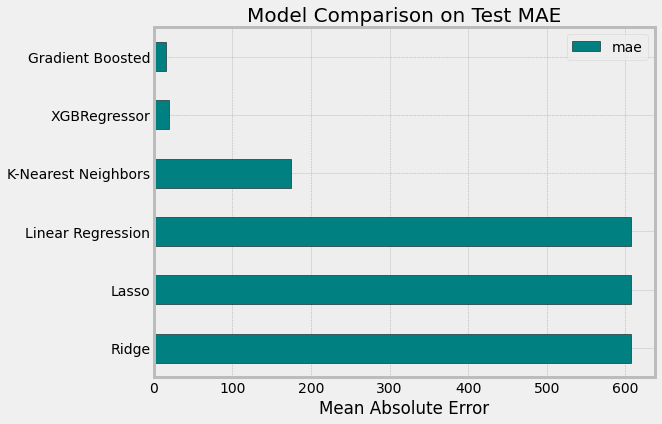

In [ ]:
plt.style.use('fivethirtyeight')
figsize(8, 6)

# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression',
                                            'Gradient Boosted',
                                            'K-Nearest Neighbors', 'XGBRegressor', 'Ridge', 'Lasso'],
                                 'mae': [lr_mae,
                                         gradient_boosted_mae, knn_mae, xgb_mae, ridge_mae, lasso_mae]})

# Horizontal bar chart of test mae
model_comparison.sort_values('mae', ascending = False).plot(x = 'model', y = 'mae', kind = 'barh',
                                                           color = '#008080', edgecolor = 'black')

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14); plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 20)

I am going to concentrate on optimizing the best model using hyperparamter tuning. Given the results here, I will concentrate on using the XGBRegressor (scikit-Learn version GradientBoostingRegressor is generally slower than the XGBoost version)


## **Hyperparameter Tuning with Random Search and Cross Validation**

I can choose the best hyperparameters for a model through random search and cross validation. I selected 6 different hyperparameters to tune in the XGBregressor.

In [ ]:
# Define the grid of hyperparameters to search
param_lst = {
    'learning_rate' : [0.01, 0.1, 0.15, 0.3, 0.5],
    'n_estimators' : [100, 500, 1000, 2000, 3000],
    'max_depth' : [3, 6, 9],
    'min_child_weight' : [1, 5, 10, 20],
    'reg_alpha' : [0.001, 0.01, 0.1],
    'reg_lambda' : [0.001, 0.01, 0.1]
}

# Set up the random search with 5-fold cross validation
xgb_reg = RandomizedSearchCV(estimator = xgb, param_distributions = param_lst,
                              n_iter = 30, scoring = 'neg_mean_absolute_error',
                              cv = 5)
# Fit on the training data
xgb_search = xgb_reg.fit(X, y)

In [ ]:
xgb_search.best_estimator_

XGBRegressor(max_depth=9, n_estimators=500, objective='reg:squarederror',
             reg_alpha=0.1, reg_lambda=0.01)

## Evaluate Final Model on the Test **Set**

I will use the best model from hyperparameter tuning to make predictions on the testing set.

For comparison, I can also look at the performance of the default model.

In [ ]:
# Default model
default_model = XGBRegressor(booster='gbtree', objective='reg:squarederror')

# Select the best model
final_model = xgb_search.best_estimator_

In [ ]:
default_model.fit(X, y)

XGBRegressor(objective='reg:squarederror')

In [ ]:
final_model.fit(X, y)

XGBRegressor(max_depth=9, n_estimators=500, objective='reg:squarederror',
             reg_alpha=0.1, reg_lambda=0.01)

In [ ]:
# Compare default and final model
default_pred = default_model.predict(X_test)
final_pred = final_model.predict(X_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set:   MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 19.7914.
Final model performance on the test set:   MAE = 1.0820.


The model showed excellent results!

## **Interprete the Model**

Interpreting the information I received from the model

In [ ]:
# read the file to display the column names
train_features = pd.read_csv('training_features.csv')
test_features = pd.read_csv('testing_features.csv')

# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns),
                                'importance': final_model.feature_importances_})

# Show the most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(8)

,feature,importance
0,fuelCost08,0.972556
1,barrels08,0.021865
2,cylinders,0.003963
3,drive,0.000971
4,trany,0.000287
5,fuelType1,0.000227
6,highway08,0.000101
7,displ,0.000030


Here are the features that most allow to predict fuel costs and savings. Not surprisingly, "fuelCost" has a significant advantage, since, as we found out above in the EDA, this feature correlates very strongly with the target.

For the experiment, let's try to find out which features are most important if we remove the "fuelCost"

In [ ]:
# Remove FuelCost08 from dataset, train and predict without FuelCost08
X_w = train_features.drop(['fuelCost08'], axis=1)
X_test_w = test_features.drop(['fuelCost08'], axis=1)
final_model.fit(X_w, y)
final_pred_w = final_model.predict(X_test_w)
print('Final model performance on the test set without FuelCOst:   MAE = %0.4f.' % mae(y_test, final_pred_w))

Final model performance on the test set without FuelCOst:   MAE = 2.0177.


In [ ]:
# Show the most important features without FuelCost08
feature_results_without_FuelCost = pd.DataFrame({'feature': list(X_w.columns),
                                'importance': final_model.feature_importances_})

feature_results_without_FuelCost = feature_results_without_FuelCost.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results_without_FuelCost.head(7)

,feature,importance
0,barrels08,0.525436
1,fuelType1,0.435705
2,highway08,0.035448
3,cylinders,0.002349
4,displ,0.000882
5,drive,0.000133
6,trany,0.000047


## **Make Conclusions**

In conclusion, I will briefly write what we learned from the project:

* Using the given fuel economy data, a machine learning model can predict the
fuel economy within 2 points.
* The most important variables for determining the Fuel Economy Score are the fuelCost08, barrels08, and fuelType1.